In [1]:

import torch, cv2, mediapipe as mp, onnxruntime as ort, numpy as np
print("PyTorch ", torch.__version__)
print("OpenCV  ", cv2.__version__)
print("MediaPipe ", mp.__version__)
print("ONNX RT ", ort.__version__)
print("CUDA or MPS available? ", torch.cuda.is_available() or torch.backends.mps.is_available())



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/rgu/miniconda3/envs/pfpt-v0/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/rgu/miniconda3/envs/pfpt-v0/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/rgu/miniconda3/envs/pfpt-v0/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self

PyTorch  2.2.2
OpenCV   4.12.0
MediaPipe  0.10.9
ONNX RT  1.22.1
CUDA or MPS available?  True


In [10]:
# notebooks/eda.ipynb  (or just a script)

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

RAW = Path("~/pfpt-demo/data/raw").expanduser()

# 1) load one sequence
seq = np.load(RAW/"2d_joints/Camera17/04.npy")  # any file
print(seq.shape)      # -> (frames, 26, 2)

# 2) quick skeleton plot for the first frame
pairs = [(0,1),(1,2),(2,3),(0,4),(4,5),(5,6),  # hips→knees→ankles, spine→shoulders→wrists
         (4,7),(7,8), (0,9)]                   # spine to head

plt.figure(figsize=(4,6))
frame0 = seq[0]
for a,b in pairs:
    plt.plot([frame0[a,0], frame0[b,0]],
             [frame0[a,1], frame0[b,1]], '-o')
plt.gca().invert_yaxis(); plt.axis('equal'); plt.show()

# 3) load Segmentation.csv and look at the three PF exercises
seg = pd.read_csv(RAW/"Segmentation.csv")
pfpt_ids = [4,5,6]                # Ex4-leg-abduction, Ex5-lunge, Ex6-squat
print(seg[seg['ExerciseID'].isin(pfpt_ids)].head())
print("Correct reps vs incorrect:")
print(seg[seg['ExerciseID'].isin(pfpt_ids)]['Correctness'].value_counts())


FileNotFoundError: [Errno 2] No such file or directory: '/Users/rgu/pfpt-demo/data/raw/2d_joints/Camera17/04.npy'

In [136]:

import cv2, mediapipe_adapter as mpad

frame = cv2.imread('any.png')      # make sure it exists
assert frame is not None, "image not found"

kps = mpad.extract_kps(frame)
print(kps.shape if kps is not None else "no pose")


(17, 2)


<h1>debugging: sanity check for opencv 33 to coco17</h1>

In [139]:
cd ..

/Users/rgu/Desktop/projects/mendhai_cv_v0


In [11]:
import numpy as np
import cv2
from pathlib import Path

# ---- USER: change this to any window file you want to inspect ------------
window_path = Path("data/processed_data/windows")  # folder
# automatically pick the first .npz found so the cell runs without edits
window_file = next(window_path.glob("*.npz"))

print("Inspecting:", window_file)

npz = np.load(window_file)
xyz = npz["xyz"]          # (64,17,2)  -- xyz[:,:,0]=x, xyz[:,:,1]=y

# pick the very first frame of the 64‑frame window
frame_xy = xyz[0]         # (17,2)

# turn normalised coords [0,1] into pixel coords on a 640x480 canvas
H, W = 480, 640
pts = (frame_xy * [W, H]).astype(int)

canvas = np.ones((H, W, 3), dtype=np.uint8) * 255

# draw joints
for x, y in pts:
    cv2.circle(canvas, (x, y), 5, (0, 0, 255), -1)

# draw simple limbs (shoulder‑hip‑knee‑ankle both sides)
limbs = [(0,1),(1,2),(2,3),  # left leg
         (0,4),(4,5),(5,6),  # right leg
         (7,8),(8,9),        # left arm
         (7,10),(10,11),(11,12)]  # right arm
for i,j in limbs:
    cv2.line(canvas, tuple(pts[i]), tuple(pts[j]), (0,128,0), 2)

# write the image so the user can download / view
out_path = "skeleton_preview.png"
cv2.imwrite(out_path, canvas)
out_path


StopIteration: 

In [145]:
cd ..

/Users/rgu/Desktop/projects/mendhai_cv_v0


In [165]:
#!/usr/bin/env python3
import json
import torch
import numpy as np
from pathlib import Path

# ensure src/ is on PYTHONPATH so imports work
from model import BiLSTMClassifier
from utils import centre_scale

# ─── files relative to project root ───────────────────────────────
manifest_path = Path("data/processed_data/manifest.json")
windows_dir   = Path("data/processed_data/windows")
model_path    = Path("artifacts/bilstm_live_8_4.pt")   # TorchScript file

# ─── load manifest & pick the first window ─────────────────────────
manifest = json.load(open(manifest_path))
entry    = manifest[0]
gt       = entry["label"]

# ─── locate the .npz window file ───────────────────────────────────
win_file = Path(entry["path"]).name
win_path = windows_dir / win_file
assert win_path.exists(), f"Window file not found: {win_path}"

# ─── load the (64,17,2) window array ───────────────────────────────
xyz = np.load(win_path)["xyz"]               # already centre-scaled
xyz = centre_scale(xyz)                      # mimic live prep
clip = torch.tensor(xyz, dtype=torch.float32) \
             .flatten(1).unsqueeze(0)        # shape = (1,64,34)

# ─── load the TorchScript module & run inference ───────────────────
assert model_path.exists(), f"Model file not found: {model_path}"
net = torch.jit.load(model_path, map_location="cpu")
net.eval()

pred = net(clip).argmax(1).item()

# ─── report ─────────────────────────────────────────────────────────
labels = ["bg", "leg_abduction", "lunge", "squat"]
print(f"Window:           {win_file}")
print(f"Ground-truth:     {gt} → {labels[gt]}")
print(f"Model prediction: {pred} → {labels[pred]}")


Window:           PM_005_bg_c17_00000.npz
Ground-truth:     0 → bg
Model prediction: 0 → bg


In [2]:
cd src


/Users/rgu/Desktop/projects/mendhai_cv_v0/src


In [7]:
import numpy as np, torch
from pathlib import Path
from utils import centre_scale

# ── load the saved live buffer ────────────────────────────────────────
xyz_live = np.load("tmp_live_clip.npy")   # shape = (64,17,2)

# ── apply the same scale centering you do live ───────────────────────
xyz_live = centre_scale(xyz_live)

# ── build a batch for the scripted model ────────────────────────────
clip = torch.tensor(xyz_live, dtype=torch.float32) \
             .flatten(1).unsqueeze(0)  # shape = (1,64,34)

# ── load and run your TorchScript model ─────────────────────────────
model = torch.jit.load(str(Path("../artifacts/bilstm_live_8_4.pt")), map_location="cpu")
model.eval()

probs = model(clip).softmax(1)[0].detach().cpu().numpy()
labels = ["bg", "leg_abduction", "lunge", "squat"]

print("Offline live-clip probabilities:")
for lbl, p in zip(labels, probs):
    print(f"  {lbl:15}: {p:.3f}")

pred = probs.argmax()
print("→ Predicted:", labels[pred])


Offline live-clip probabilities:
  bg             : 0.000
  leg_abduction  : 0.000
  lunge          : 0.999
  squat          : 0.000
→ Predicted: lunge


<h1>testing rehab24-6 vs the translated coco17 joints</h1>

In [13]:
pwd

'/Users/rgu/Desktop/projects/mendhai_cv_v0/src'

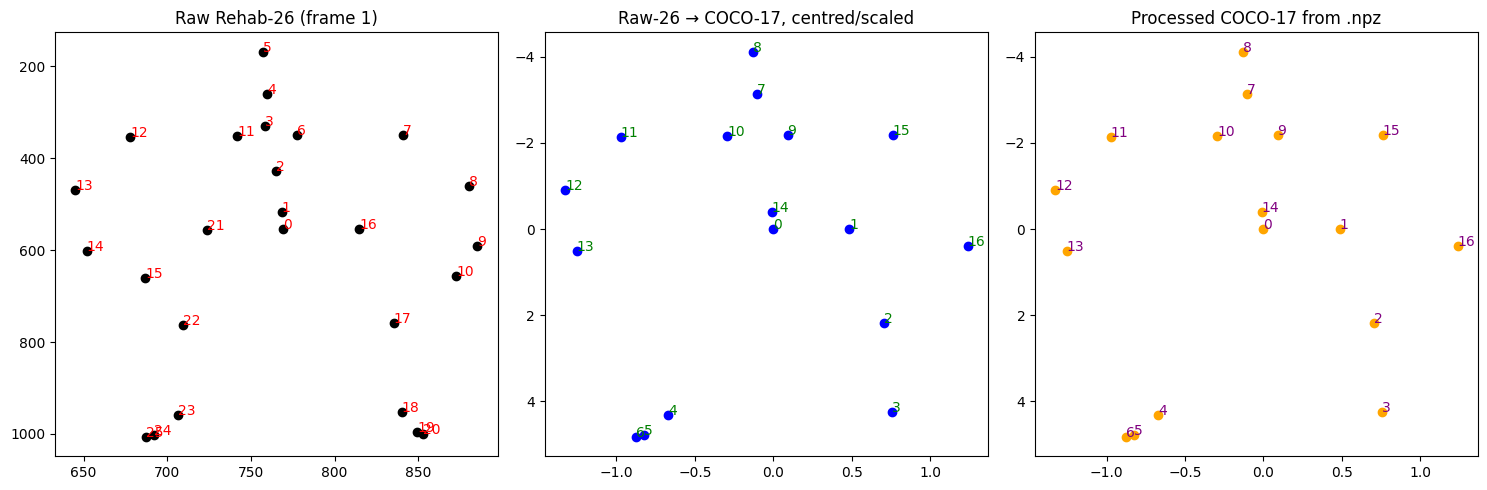

In [26]:
 # 1) Make sure Python can see your src/ folder
import sys
from pathlib import Path
for p in ("src", "."):
    p = Path(p)
    if p.exists():
        sys.path.insert(0, str(p.resolve()))

import numpy as np
import matplotlib.pyplot as plt

# Paste in the mapping funcs so you don't have import issues:
MAP_26_TO_17 = {
    0:0, 16:1,17:2,18:3, 23:4,24:5,25:6,
    4:7,5:8,6:9, 11:10,12:11, 13:12,14:13,
    1:14, 7:15,9:16
}
def to_coco17(x26):
    out = np.full((x26.shape[0],17,2), np.nan, np.float32)
    for s,d in MAP_26_TO_17.items():
        out[:,d] = x26[:,s]
    return out

def centre_scale(x17):
    PELVIS=0; LSHO=7; RSHO=10
    pelvis = x17[:, PELVIS:PELVIS+1]
    cen = x17 - pelvis
    shw = np.linalg.norm(cen[:,LSHO] - cen[:,RSHO], axis=-1, keepdims=True)+1e-6
    return cen / shw[...,None]

# 2) Adjust these to your files:
raw_npy = Path("../data/raw_data/2d_joints/Ex4/PM_005-c17-30fps.npy")
win_npz  = Path("../data/processed_data/windows/PM_005_bg_c17_00000.npz")

# 3) Load first frame of raw (26 joints) and processed (17 joints)
raw26     = np.load(raw_npy)[0]                    # (26,2)
proc17    = np.load(win_npz)["xyz"][0]             # (17,2)

# also map & scale raw → coco17 for fair comparison
mapped17  = to_coco17(raw26[None])[0]              # (17,2)
mapped17_sc = centre_scale(mapped17[None])[0]     # (17,2)

# 4) Plot
fig, axs = plt.subplots(1,3, figsize=(15,5))

# a) Raw rehab-26
axs[0].scatter(raw26[:,0], raw26[:,1], c='k')
for i,(x,y) in enumerate(raw26):
    axs[0].text(x,y,str(i), color='r')
axs[0].set_title("Raw Rehab-26 (frame 1)")
axs[0].invert_yaxis()

# b) Mapped & scaled from raw
axs[1].scatter(mapped17_sc[:,0], mapped17_sc[:,1], c='b')
for i,(x,y) in enumerate(mapped17_sc):
    axs[1].text(x,y,str(i), color='g')
axs[1].set_title("Raw-26 → COCO-17, centred/scaled")
axs[1].invert_yaxis()

# c) Your processed .npz output
axs[2].scatter(proc17[:,0], proc17[:,1], c='orange')
for i,(x,y) in enumerate(proc17):
    axs[2].text(x,y,str(i), color='purple')
axs[2].set_title("Processed COCO-17 from .npz")
axs[2].invert_yaxis()

plt.tight_layout()
plt.show()


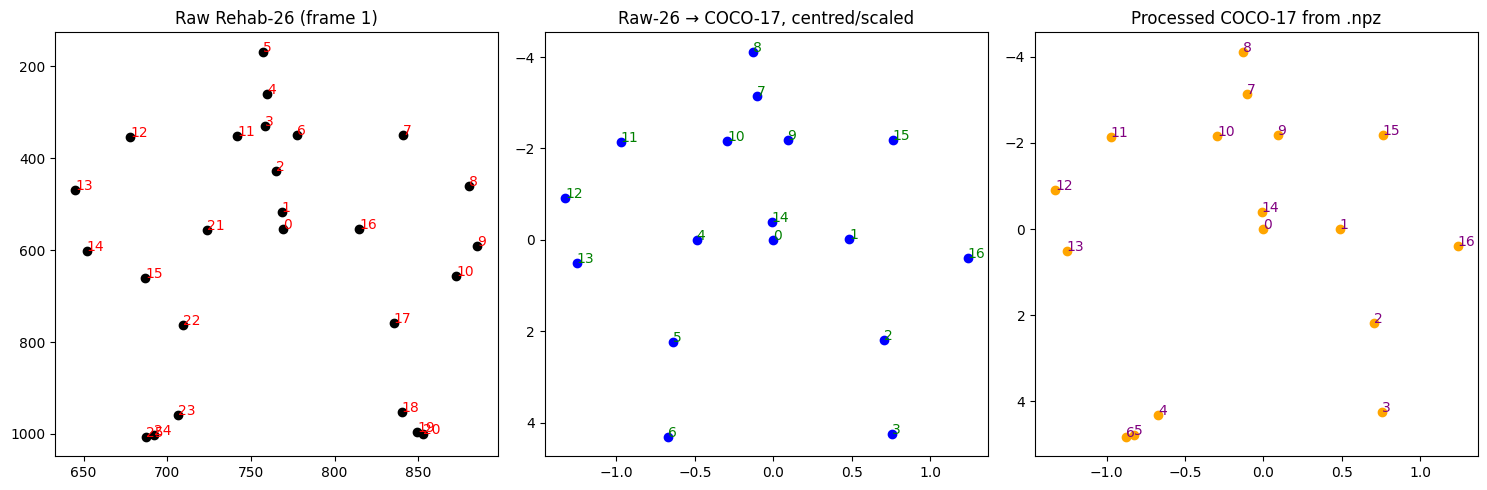

In [ ]:
 # 1) Make sure Python can see your src/ folder
import sys
from pathlib import Path
for p in ("src", "."):
    p = Path(p)
    if p.exists():
        sys.path.insert(0, str(p.resolve()))

import numpy as np
import matplotlib.pyplot as plt

# Paste in the mapping funcs so you don't have import issues:
MAP_26_TO_17 = {
    0:0, 16:1,17:2,18:3, 21:4,22:5,23:6,
    4:7,5:8,6:9, 11:10,12:11, 13:12,14:13,
    1:14, 7:15,9:16
}
def to_coco17(x26):
    out = np.full((x26.shape[0],17,2), np.nan, np.float32)
    for s,d in MAP_26_TO_17.items():
        out[:,d] = x26[:,s]
    return out

def centre_scale(x17):
    PELVIS=0; LSHO=7; RSHO=10
    pelvis = x17[:, PELVIS:PELVIS+1]
    cen = x17 - pelvis
    shw = np.linalg.norm(cen[:,LSHO] - cen[:,RSHO], axis=-1, keepdims=True)+1e-6
    return cen / shw[...,None]

# 2) Adjust these to your files:
raw_npy = Path("../data/raw_data/2d_joints/Ex4/PM_005-c17-30fps.npy")
win_npz  = Path("../data/processed_data/windows/PM_005_bg_c17_00000.npz")

# 3) Load first frame of raw (24 joints) and processed (17 joints)
raw26     = np.load(raw_npy)[0]                    # (24,2)
proc17    = np.load(win_npz)["xyz"][0]             # (17,2)

# also map & scale raw → coco17 for fair comparison
mapped17  = to_coco17(raw26[None])[0]              # (17,2)
mapped17_sc = centre_scale(mapped17[None])[0]     # (17,2)

# 4) Plot
fig, axs = plt.subplots(1,3, figsize=(15,5))

# a) Raw rehab-24
axs[0].scatter(raw26[:,0], raw26[:,1], c='k')
for i,(x,y) in enumerate(raw26):
    axs[0].text(x,y,str(i), color='r')
axs[0].set_title("Raw Rehab-24 (frame 1)")
axs[0].invert_yaxis()

# b) Mapped & scaled from raw
axs[1].scatter(mapped17_sc[:,0], mapped17_sc[:,1], c='b')
for i,(x,y) in enumerate(mapped17_sc):
    axs[1].text(x,y,str(i), color='g')
axs[1].set_title("Raw-24 → COCO-17, centred/scaled")
axs[1].invert_yaxis()

# c) Your processed .npz output
axs[2].scatter(proc17[:,0], proc17[:,1], c='orange')
for i,(x,y) in enumerate(proc17):
    axs[2].text(x,y,str(i), color='purple')
axs[2].set_title("Processed COCO-17 from .npz")
axs[2].invert_yaxis()

plt.tight_layout()
plt.show()


In [ ]:
| Index | Name                    |
| :---: | ----------------------- |
|   0   | Hips (pelvis)           |
|   1   | Spine                   |
|   2   | Spine1                  |
|   3   | Neck                    |
|   4   | Head                    |
|   5   | Head\_end (top of head) |
|   6   | LeftShoulder            |
|   7   | LeftArm                 |
|   8   | LeftForeArm             |
|   9   | LeftHand                |
|   10  | LeftHand\_end           |
|   11  | RightShoulder           |
|   12  | RightArm                |
|   13  | RightForeArm            |
|   14  | RightHand               |
|   15  | RightHand\_end          |
|   16  | LeftUpLeg               |
|   17  | LeftLeg                 |
|   18  | LeftFoot                |
|   19  | LeftToeBase             |
|   20  | LeftToeBase\_end        |
|   21  | RightUpLeg              |
|   22  | RightLeg                |
|   23  | RightFoot               |
|   24  | RightToeBase            |
|   25  | RightToeBase\_end       |


<h1>testing mediapipe pose estimation and mapping</h1>

In [18]:
pwd

'/Users/rgu/Desktop/projects/mendhai_cv_v0/src'

I0000 00:00:1754418197.173462 10951470 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1 Pro
W0000 00:00:1754418197.352075 11711293 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754418197.380422 11711291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


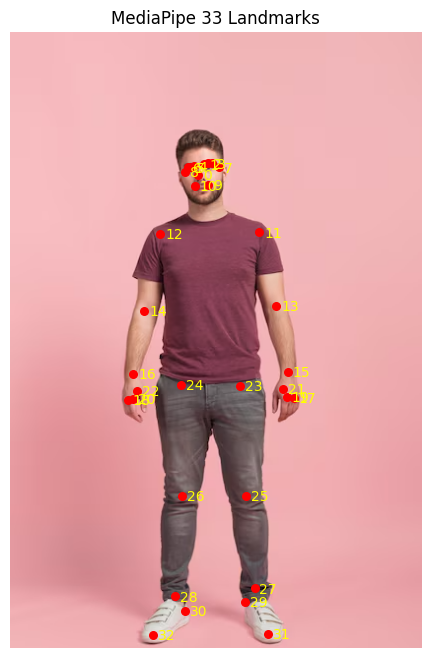

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Try to import mediapipe; if not installed, prompt the user
try:
    import mediapipe as mp
except ModuleNotFoundError:
    raise ModuleNotFoundError(
        "mediapipe library not found. Please install it with:\n"
        "  pip install mediapipe"
    )

# Path to your neutral pose image
IMAGE_PATH = "../neutral_pose.jpg"  # Replace with your image path

# Load image
img_bgr = cv2.imread(IMAGE_PATH)
if img_bgr is None:
    raise FileNotFoundError(f"Cannot find image at {IMAGE_PATH}")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True,
                    model_complexity=1,
                    enable_segmentation=False,
                    min_detection_confidence=0.5)

# Process image
results = pose.process(img_rgb)
pose.close()

if not results.pose_landmarks:
    raise RuntimeError("No pose detected in the image.")

# Extract 33 landmarks
landmarks = results.pose_landmarks.landmark
pts = np.array([[lm.x, lm.y] for lm in landmarks])  # normalized coordinates

# Joint index names
JOINT_NAMES_33 = [
    "nose", "left_eye_inner", "left_eye", "left_eye_outer",
    "right_eye_inner", "right_eye", "right_eye_outer",
    "left_ear", "right_ear", "mouth_left", "mouth_right",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_pinky", "right_pinky",
    "left_index", "right_index", "left_thumb", "right_thumb",
    "left_hip", "right_hip", "left_knee", "right_knee",
    "left_ankle", "right_ankle", "left_heel", "right_heel",
    "left_foot_index", "right_foot_index"
]

# Plot
plt.figure(figsize=(6, 8))
plt.imshow(img_rgb)
plt.axis('off')

h, w = img_rgb.shape[:2]
pts_px = (pts * [w, h]).astype(int)

# Scatter joints and label
for idx, (x, y) in enumerate(pts_px):
    plt.scatter(x, y, s=30, c='red')
    plt.text(x + 5, y + 5, f"{idx}", color='yellow', fontsize=10)

plt.title("MediaPipe 33 Landmarks")
plt.show()


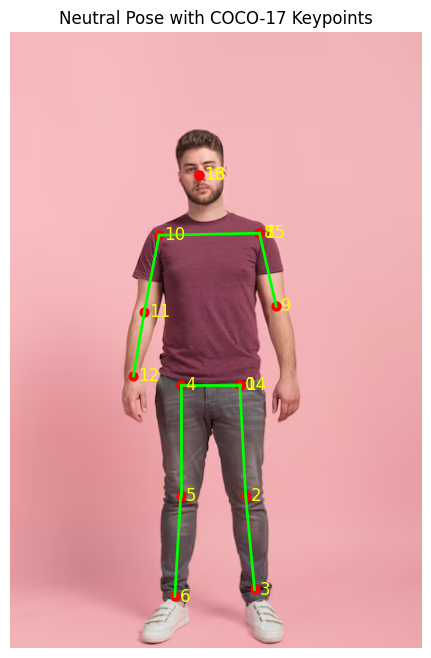

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mediapipe_adapter import extract_kps

# Path to your neutral-pose image
IMAGE_PATH = "../neutral_pose.jpg"  # replace with your image file

# Load image
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise FileNotFoundError(f"Image not found: {IMAGE_PATH}")

# Extract COCO-17 keypoints
kps = extract_kps(img)
if kps is None:
    raise RuntimeError("No pose detected; try another neutral pose photo.")

# Convert BGR to RGB for plotting
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot image
plt.figure(figsize=(6,8))
plt.imshow(img_rgb)
plt.title("Neutral Pose with COCO-17 Keypoints")
plt.axis('off')

# Overlay joints
h, w = img.shape[:2]
pts = (kps * [w, h]).astype(int)

for idx, (x, y) in enumerate(pts):
    plt.scatter(x, y, c='red', s=40)
    plt.text(x+5, y+5, str(idx), color='yellow', fontsize=12)

# Connect limbs
LIMBS = [
    (0,1),(1,2),(2,3),            # Left arm: shoulder->elbow->wrist
    (0,4),(4,5),(5,6),            # Right arm
    (7,8),(8,9),                  # Left leg: hip->knee->ankle
    (7,10),(10,11),(11,12)        # Right leg
]
for a, b in LIMBS:
    xa, ya = pts[a]
    xb, yb = pts[b]
    plt.plot([xa, xb], [ya, yb], c='lime', linewidth=2)

plt.show()


I0000 00:00:1754419389.477781 10951470 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1 Pro
W0000 00:00:1754419389.649805 11771101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754419389.673529 11771102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


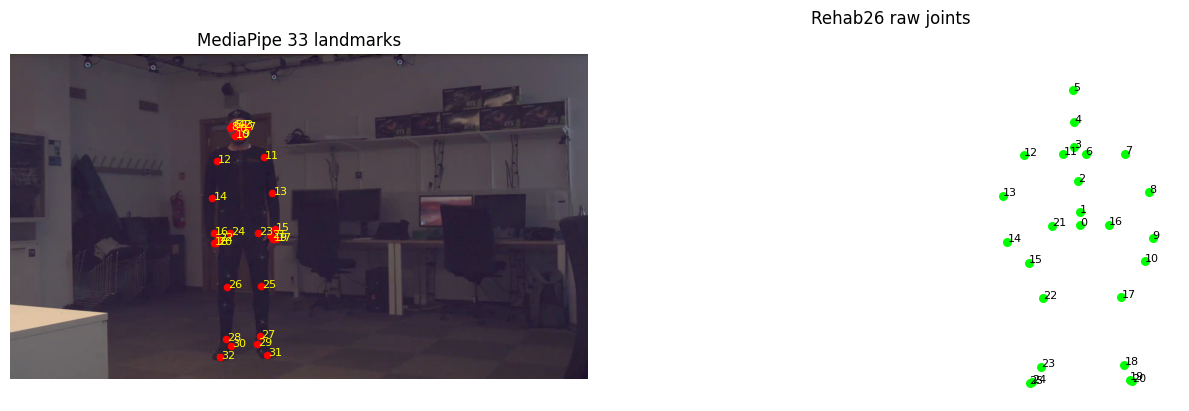

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

# 1. Paths — adjust as needed
VIDEO_PATH = "../data/videos/Ex4/PM_005-Camera17-30fps.mp4"
RAW26_NPY  = "../data/raw_data/2d_joints/Ex4/PM_005-c17-30fps.npy"

# 2. Grab frame 0 from the video
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open video: {VIDEO_PATH}")
ret, frame_bgr = cap.read()
cap.release()
if not ret:
    raise RuntimeError("Failed to read frame 0")

frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
h, w = frame_rgb.shape[:2]

# 3. MediaPipe: extract all 33 landmarks
mp_pose = mp.solutions.pose.Pose(static_image_mode=True,
                                model_complexity=1,
                                enable_segmentation=False,
                                min_detection_confidence=0.5)
res = mp_pose.process(frame_rgb)
mp_pose.close()
if not res.pose_landmarks:
    raise RuntimeError("No pose found in frame")

mp_pts = np.array([[lm.x, lm.y] for lm in res.pose_landmarks.landmark])  # (33,2)
mp_px  = (mp_pts * [w, h]).astype(int)

# 4. Load Rehab26 raw joints (frame 0)
raw26 = np.load(RAW26_NPY)[0]    # (26,2) in normalized coords
rehab_px = (raw26 * [w, h]).astype(int)

# 5. Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# a) MediaPipe-33
ax1.imshow(frame_rgb)
ax1.set_title("MediaPipe 33 landmarks")
ax1.axis("off")
for i, (x,y) in enumerate(mp_px):
    ax1.scatter(x, y, c="red", s=20)
    ax1.text(x+4, y+4, str(i), color="yellow", fontsize=8)

# b) Rehab26
ax2.imshow(frame_rgb)
ax2.set_title("Rehab26 raw joints")
ax2.axis("off")
for i, (x,y) in enumerate(rehab_px):
    ax2.scatter(x, y, c="lime", s=30)
    ax2.text(x+4, y+4, str(i), color="black", fontsize=8)

plt.tight_layout()
plt.show()


<h1>new pfpt-15 mapping</h1>

In [30]:
pwd

'/Users/rgu/Desktop/projects/mendhai_cv_v0/src'

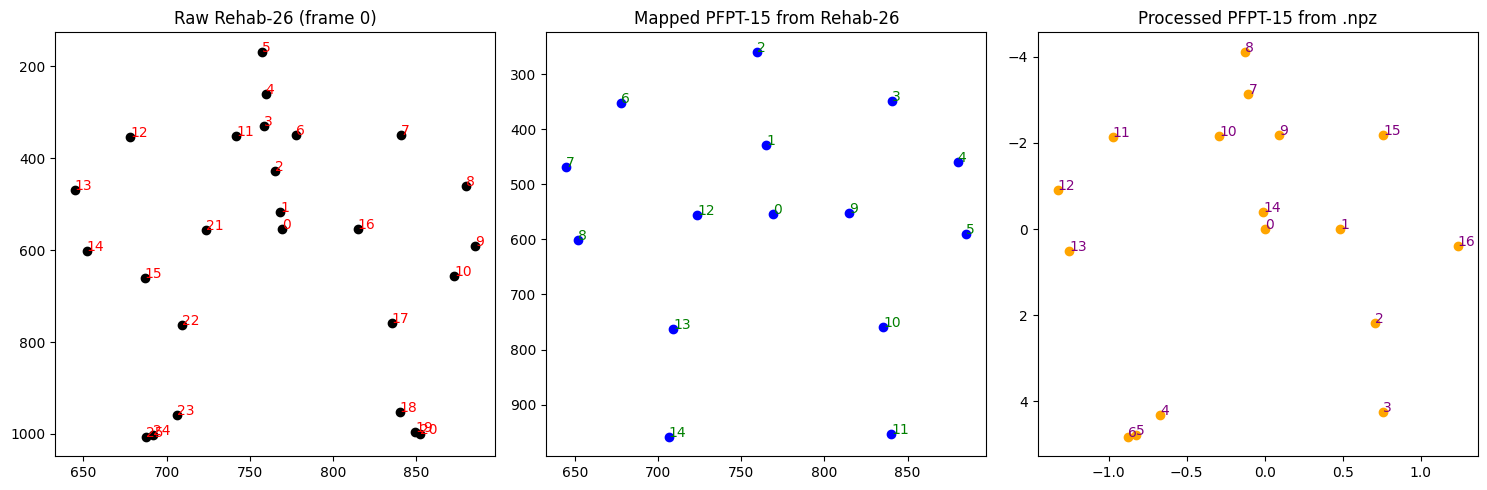

In [32]:
import sys
from pathlib import Path

# ── Ensure project src is on path ────────────────────────────────────
sys.path.insert(0, str(Path("src").resolve()))

import numpy as np
import matplotlib.pyplot as plt

# ── PFPT-15 mapping for Rehab26 ──────────────────────────────────────
REHAB26_TO_PFPT15 = {
     0:  0,  # pelvis
     2:  1,  # spine1 -> mid_spine
     4:  2,  # head -> head
     7:  3,  # LeftArm -> L_shoulder
     8:  4,  # LeftForeArm  -> L_elbow
     9:  5,  # LeftHand     -> L_wrist
    12:  6,  # RightArm-> R_shoulder
    13:  7,  # RightForeArm -> R_elbow
    14:  8,  # RightHand    -> R_wrist
    16:  9,  # LeftUpLeg    -> L_hip
    17: 10,  # LeftLeg      -> L_knee
    18: 11,  # LeftFoot     -> L_ankle
    21: 12,  # RightUpLeg   -> R_hip
    22: 13,  # RightLeg     -> R_knee
    23: 14,  # RightFoot    -> R_ankle
}

def rehab26_to_pfpt15(raw26):
    """
    raw26: (26,2) or (T,26,2)
    returns: (15,2) or (T,15,2)
    """
    arr = raw26
    squeeze = False
    if arr.ndim == 2:
        arr = arr[np.newaxis, ...]
        squeeze = True
    T = arr.shape[0]
    out = np.zeros((T, 15, 2), dtype=arr.dtype)
    # direct copy for defined joints
    for r26, p15 in REHAB26_TO_PFPT15.items():
        out[:, p15, :] = arr[:, r26, :]
    if squeeze:
        return out[0]
    return out

# ── Paths: adjust as needed ───────────────────────────────────────────
raw_npy = Path("../data/raw_data/2d_joints/Ex4/PM_005-c17-30fps.npy")
win_npz  = Path("../data/processed_data/windows/PM_005_bg_c17_00000.npz")

# ── Load data ────────────────────────────────────────────────────────
raw26 = np.load(raw_npy)[0]          # (26,2)
pfpt15_mapped = rehab26_to_pfpt15(raw26)  # (15,2)
proc15 = np.load(win_npz)["xyz"][0]   # assume this now contains PFPT-15 joints

# ── Plot raw26, mapped15, processed15 ───────────────────────────────
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# a) Raw Rehab-26
axs[0].scatter(raw26[:, 0], raw26[:, 1], c='black')
for i, (x, y) in enumerate(raw26):
    axs[0].text(x, y, str(i), color='red')
axs[0].set_title("Raw Rehab-26 (frame 0)")
axs[0].invert_yaxis()

# b) Mapped PFPT-15 from raw26
axs[1].scatter(pfpt15_mapped[:, 0], pfpt15_mapped[:, 1], c='blue')
for i, (x, y) in enumerate(pfpt15_mapped):
    axs[1].text(x, y, str(i), color='green')
axs[1].set_title("Mapped PFPT-15 from Rehab-26")
axs[1].invert_yaxis()

# c) Processed PFPT-15 from .npz
axs[2].scatter(proc15[:, 0], proc15[:, 1], c='orange')
for i, (x, y) in enumerate(proc15):
    axs[2].text(x, y, str(i), color='purple')
axs[2].set_title("Processed PFPT-15 from .npz")
axs[2].invert_yaxis()

plt.tight_layout()
plt.show()


I0000 00:00:1754424408.514555 10951470 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1 Pro
W0000 00:00:1754424408.765804 11965921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754424408.833909 11965916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


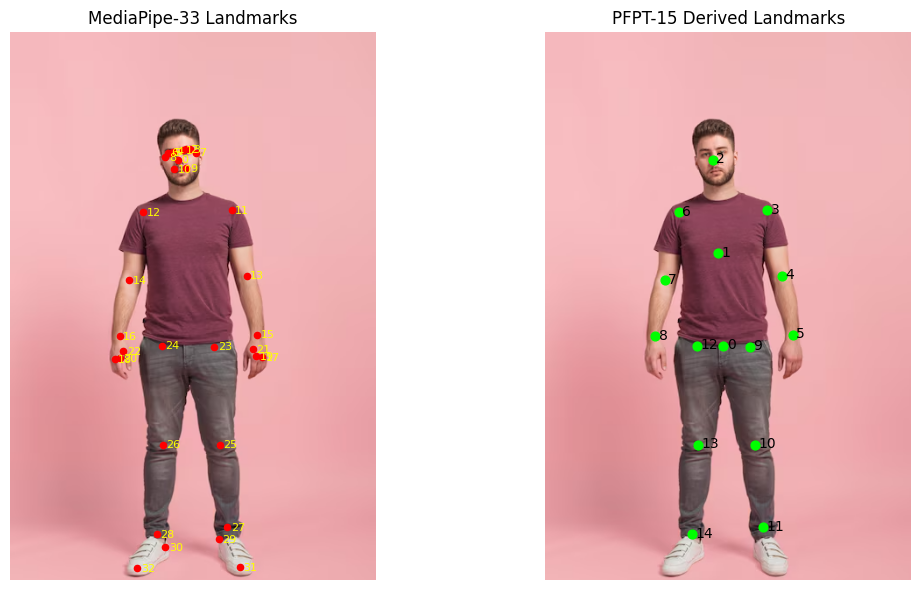

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from pathlib import Path

# ── PFPT-15 mapping for MediaPipe-33 ──────────────────────────────────
MP33_TO_PFPT15 = {
     0:  2,   # nose → head
    11:  3,   # left_shoulder → L_shoulder
    13:  4,   # left_elbow    → L_elbow
    15:  5,   # left_wrist    → L_wrist
    12:  6,   # right_shoulder→ R_shoulder
    14:  7,   # right_elbow   → R_elbow
    16:  8,   # right_wrist   → R_wrist
    23:  9,   # left_hip      → L_hip
    25: 10,   # left_knee     → L_knee
    27: 11,   # left_ankle    → L_ankle
    24: 12,   # right_hip     → R_hip
    26: 13,   # right_knee    → R_knee
    28: 14,   # right_ankle   → R_ankle
}

def mp33_to_pfpt15(mpkps: np.ndarray) -> np.ndarray:
    """
    Convert MediaPipe-33 landmarks to PFPT-15 skeleton.
    mpkps: (33,2) normalized coords
    returns: (15,2)
    """
    # Pelvis = midpoint of left_hip (23) & right_hip (24)
    lh = mpkps[23]
    rh = mpkps[24]
    pelvis = (lh + rh) / 2.0

    # Mid-spine = midpoint of pelvis & nose (0)
    nose = mpkps[0]
    mid_spine = (pelvis + nose) / 2.0

    out = np.zeros((15, 2), dtype=mpkps.dtype)
    out[0] = pelvis
    out[1] = mid_spine
    out[2] = nose

    # Direct mappings
    for mp_idx, p15_idx in MP33_TO_PFPT15.items():
        out[p15_idx] = mpkps[mp_idx]

    return out

# ── Load neutral pose image ─────────────────────────────────────────
IMAGE_PATH = Path("../neutral_pose.jpg")
img_bgr = cv2.imread(str(IMAGE_PATH))
if img_bgr is None:
    raise FileNotFoundError(f"Cannot load {IMAGE_PATH}")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h, w = img_rgb.shape[:2]

# ── MediaPipe detection ─────────────────────────────────────────────
mp_pose = mp.solutions.pose.Pose(static_image_mode=True,
                                model_complexity=1,
                                enable_segmentation=False,
                                min_detection_confidence=0.5)
results = mp_pose.process(img_rgb)
mp_pose.close()

if not results.pose_landmarks:
    raise RuntimeError("No pose landmarks detected.")

mp_pts = np.array([[lm.x, lm.y] for lm in results.pose_landmarks.landmark])  # (33,2)
mp_px = (mp_pts * [w, h]).astype(int)

pfpt15_pts = mp33_to_pfpt15(mp_pts)  # (15,2)
pfpt15_px = (pfpt15_pts * [w, h]).astype(int)

# ── Plot side-by-side ────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# a) MediaPipe-33
ax1.imshow(img_rgb)
ax1.set_title("MediaPipe-33 Landmarks")
ax1.axis("off")
for idx, (x, y) in enumerate(mp_px):
    ax1.scatter(x, y, c='red', s=20)
    ax1.text(x+4, y+4, str(idx), color='yellow', fontsize=8)

# b) PFPT-15 from MediaPipe
ax2.imshow(img_rgb)
ax2.set_title("PFPT-15 Derived Landmarks")
ax2.axis("off")
for idx, (x, y) in enumerate(pfpt15_px):
    ax2.scatter(x, y, c='lime', s=40)
    ax2.text(x+4, y+4, str(idx), color='black', fontsize=10)

plt.tight_layout()
plt.show()


In [35]:
# %%
import numpy as np
from pathlib import Path

# path to your new windows
WINDOW_DIR = Path("../data/processed_data/windows")  # update path if needed

# list of all .npz files
npz_files = sorted(WINDOW_DIR.glob("*.npz"))

# load a few samples and check their shape
for i, fpath in enumerate(npz_files[:5]):  # check first 5 files
    data = np.load(fpath)
    xyz = data["xyz"]  # shape should be (64, 15, 2)
    label = data["label"]
    quality = data["quality"]

    print(f"\nFile: {fpath.name}")
    print(f"xyz shape  : {xyz.shape}")
    print(f"label      : {label}")
    print(f"quality    : {quality}")

    assert xyz.shape == (64, 15, 2), "❌ Shape mismatch: expected (64, 15, 2)"
    assert np.all(np.isfinite(xyz)), "❌ Contains NaNs or infs"

print("\n✅ All loaded samples have correct shape (64, 15, 2) and are finite.")



File: PM_005_bg_c17_00000.npz
xyz shape  : (64, 15, 2)
label      : 0
quality    : -1

File: PM_005_bg_c17_00032.npz
xyz shape  : (64, 15, 2)
label      : 0
quality    : -1

File: PM_005_bg_c17_00064.npz
xyz shape  : (64, 15, 2)
label      : 0
quality    : -1

File: PM_005_bg_c17_00096.npz
xyz shape  : (64, 15, 2)
label      : 0
quality    : -1

File: PM_005_bg_c17_00128.npz
xyz shape  : (64, 15, 2)
label      : 0
quality    : -1

✅ All loaded samples have correct shape (64, 15, 2) and are finite.
